# Languages used on Wikipedia, by country and over time

## Imports and definitions

In [3]:
import json
import requests
from datetime import date
import pandas as pd
import pygal
from IPython.display import SVG
import pprint
import geopandas as gpd
import country_converter as coco
from dateutil import rrule
import csv

# Important: update pygal's map: https://github.com/Kozea/pygal_maps_world/pull/5

# Function used below to display maps
def display_svg(svg_code):
     return SVG(svg_code)

pp = pprint.PrettyPrinter(indent=4)

# As specified there: https://wikimedia.org/api/rest_v1/#/
# Without your contact details you'll get an error
contact_details = 'a455bcd9 on Wikipedia / @ADssx on Twitter'
headers = {
    'User-Agent': contact_details
}

# Get all projects from the Wikimedia Foundation
projects_list_url = 'https://commons.wikimedia.org/w/api.php?action=sitematrix&smtype=language&format=json'
projects_list_json = requests.get(projects_list_url, headers=headers).text

projects = json.loads(projects_list_json)

## List of all Wikipedias

In [4]:
wiki_codes = []
id = 0

# Look the whole list
for i in projects['sitematrix']:
    # Only fetch dictionnaries
    if isinstance(projects['sitematrix'][i],dict):
        # Get the language code
        code = projects['sitematrix'][i]['code']
        
        # Avoid issue with classical orthography Belarusian Wikipedia
        if code == 'be-x-old':
            continue

        # For each language, look at all different projects
        for j in projects['sitematrix'][i]['site']:
            # If the project is a Wikipedia, add the language code to the list of Wikipedias
            if j['code'] == 'wiki':
                wiki_codes += [code]

# For testing purposes
test_mode = False
if test_mode:
    # Set to have unique languade codes in case there's a mistake in the list
    wiki_codes = set(['ary', 'en', 'ja', 'es', 'de', 'ru', 'fr', 'it', 'zh', 'pt', 'pl', 'tr', 'ko', 'ar', 'arz', 'nl', 'he', 'fa', 'id', 'hi'])
    # wiki_codes = ['fr', 'de']
    # Languages of India
    # wiki_codes = ['en', 'hi', 'ta', 'mr', 'ml', 'te', 'bn', 'kn', 'simple', 'gu']

print('Analysis of', len(wiki_codes), 'Wikipedias')

Analysis of 345 Wikipedias


## Month to analyze

In [3]:
analyze_last_month = True
if analyze_last_month:
    # By default, use the last month
    today = date.today()

    year = today.year
    month = today.month - 1

    # Special case for January
    if today.month == 1:
        year = year - 1
        month = 12

    last_month = date(year, month, 1)
else:
    # Pick any other month
    last_month = date(2021, 1, 1)

# Convert to string to add to URL
point_in_time = last_month.strftime('%Y/%m')

print('Analyzed period:', point_in_time)

Analyzed period: 2024/07


## Pageviews by country

In [4]:
# For each Wikipedia, get the number of page views in the analyzed month, by country

# API example: https://wikimedia.org/api/rest_v1/metrics/pageviews/top-by-country/fr.wikipedia/all-access/2021/01
base_url = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/top-by-country/'
complement = '/all-access/'

all_wikipedias = pd.DataFrame()
    
# Create empty DataFrame
all_languages_pageviews = pd.DataFrame()

# For each Wikipedia get the list of page views by country
for code in wiki_codes:
    project = code + '.wikipedia.org'
    
    # Fetch API
    countries_url = base_url + project + complement + point_in_time
    countries_json = requests.get(countries_url, headers=headers).text
    countries = json.loads(countries_json)
    
    # If there's no data for this language, continue to the next one
    if 'items' not in countries:
        continue

    # Transform to a dataframe
    df = pd.DataFrame.from_dict(countries['items'][0]['countries'])

    # Drop useless columns
    df = df.drop(columns=['views', 'rank'])

    # Rename one column
    df = df.rename(columns={'views_ceil': code})
    
    # Set the country code as index
    df = df.set_index('country')

    # Merging the dataframes on the country key with outer join
    all_wikipedias = pd.concat([all_wikipedias, df], axis=1)

## Most popular Wikipedias in a given country

In [5]:
country_code = 'MA'
popular_wikipedias_in_country = all_wikipedias.loc[country_code].sort_values(ascending=False)
print('\nMost popular Wikipedias in', country_code, 'in', last_month, ':')
# Only print the top 10
print(popular_wikipedias_in_country[0:10])

# Same but in %
popular_wikipedias_in_country_pct = (100. * popular_wikipedias_in_country / popular_wikipedias_in_country.sum()).round(1)
print('\nMost popular Wikipedias in', country_code, ', %:')
# Only print the top 10
print(popular_wikipedias_in_country_pct[0:10])

# Get the most popular Wikipedia by country
most_popular_by_country = all_wikipedias.idxmax(axis=1)

# Add back the index
most_popular_by_country = most_popular_by_country.reset_index()
index = 'index'
most_popular_by_country = most_popular_by_country.rename(columns={"country": index}, errors="raise")

# Rename the column
most_popular_by_country = most_popular_by_country.rename(columns={0: 'most_popular'})

# Number of countries where each edition is top
popular_wikipedias = most_popular_by_country.groupby(['most_popular']).count()
# Sort by number of countries where language is first
popular_wikipedias = popular_wikipedias.sort_values(by=[index], ascending=False)

# Languages that are number one in at least one country
top_languages = set(most_popular_by_country['most_popular'])
print('\n', len(top_languages), 'languages are first in at least one country or territory:')
print(top_languages)

# Names of countries where each edition arrives first
# We concatenate country codes
# https://stackoverflow.com/a/22221675/5285608
countries_by_language = most_popular_by_country.groupby('most_popular')[index].apply(list).to_dict()


Most popular Wikipedias in MA in 2022-12-01 :
ar     17192000.0
fr     16746000.0
en      7373000.0
es       295000.0
arz      255000.0
de       157000.0
it       121000.0
ary       81000.0
zh        79000.0
ru        76000.0
Name: MA, dtype: float64

Most popular Wikipedias in MA , %:
ar     40.2
fr     39.2
en     17.2
es      0.7
arz     0.6
de      0.4
it      0.3
ary     0.2
zh      0.2
ru      0.2
Name: MA, dtype: float64

 29 languages are first in at least one country or territory:
{'az', 'zh', 'th', 'pl', 'tr', 'hu', 'fi', 'he', 'ru', 'it', 'pt', 'en', 'fr', 'ko', 'id', 'sk', 'sv', 'fa', 'ar', 'uz', 'ja', 'bg', 'es', 'ka', 'cs', 'hy', 'de', 'nl', 'vi'}


## Save to file

In [6]:
ordered_country_list = most_popular_by_country.sort_values(by=index)
filename = point_in_time.replace('/', '-') + '.csv'
print(filename)
ordered_country_list.to_csv(path_or_buf=filename)

2022-12.csv


## Compare 2 months

In [10]:
# Get data for the two desired months from CSV files
month_a = '2022-09'
df_month_a = pd.read_csv(month_a + '.csv', usecols=[1,2]).set_index(index).rename(columns={'most_popular': month_a})
month_b = '2022-12'
df_month_b = pd.read_csv(month_b + '.csv', usecols=[1,2]).set_index(index).rename(columns={'most_popular': month_b})

# Concatenate the two months
concat_months = pd.concat([df_month_a, df_month_b], axis=1)
# Compare most popular language in each country
concat_months['compare'] = concat_months[month_a] != concat_months[month_b]
# Drop raw that didn't change
concat_months = concat_months[concat_months['compare'] == True]
print('Changes between the two months:')
print(concat_months.sort_values(by=[month_b]))

Changes between the two months:
      2022-09 2022-12  compare
index                         
KP         ar      en     True
MF         fr      en     True
UM        NaN      en     True
CC        NaN      fr     True
TF        NaN      fr     True
GE         en      ka     True
UZ         ru      uz     True
SH         en     NaN     True


## SVG map of popular languages

In [14]:
worldmap_chart = pygal.maps.World()
# pip install pygal_maps_world
worldmap_chart.title = 'Most popular Wikipedia by country (' + point_in_time + ')'

c = 0
for language in countries_by_language:
    # Threshold to appear on the map
    map_threshold = 4
    if len(countries_by_language[language]) < map_threshold:
        # Increase the count
        c += 1
        # Add countries and languages to the map
        worldmap_chart.add(language, [x.lower() for x in countries_by_language[language]])

print(c, 'languages #1 in at least', map_threshold, 'countries or territories')

# Save in a file
# javascript should be removed to allow upload on Wikimedia, maybe with add_scripts()?
# In the meantime, remove manually after export
worldmap_chart.render_to_file('chart.svg')

# Display in the notebook
svg_code = worldmap_chart.render()
display_svg(svg_code)

AttributeError: module 'pygal.maps' has no attribute 'World'

## PNG alternative of the map

-99 not found in ISOnumeric


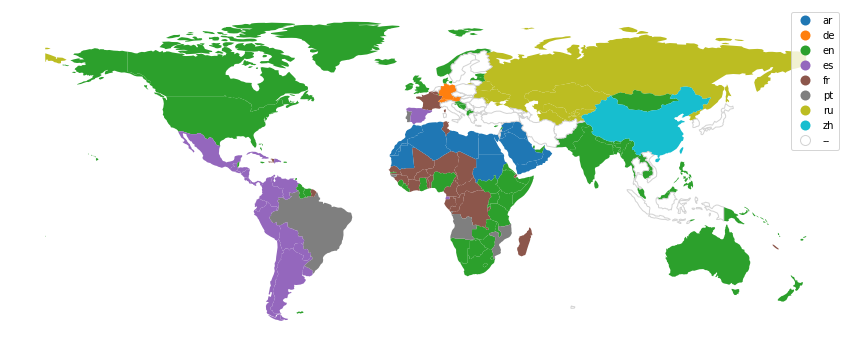

In [12]:
# Dataframe with countries and geoloc
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Add missing iso3
# https://en.wikipedia.org/wiki/ISO_3166-1_alpha-3

# Metropolitan France should have a different code from overseas territories
world.loc[world.name == 'France', 'iso_a3'] = 'FRA'
# Norway should have a different code from SJM
world.loc[world.name == 'Norway', 'iso_a3'] = 'NOR'
# Somaliland is recognized as a part of Somalia and doesn't have its own code
world.loc[world.name == 'Somaliland', 'iso_a3'] = 'SOM'
# Northern Cyprus is recognized as a part of Cyprus and doesn't have its own code
world.loc[world.name == 'N. Cyprus', 'iso_a3'] = 'CYP'

# Converting to ISO 3166-1 alpha-2 
world['iso_a2'] = coco.convert(names=world['iso_a3'].tolist(), to='ISO2')

# Kosovo doesn't have an iso3 code but an unofficial iso2 code
# https://en.wikipedia.org/wiki/ISO_3166-1_alpha-2
world.loc[world.name == 'Kosovo', 'iso_a2'] = 'XK'

# New empty column for the most read language
world['language'] = None

# Loop over the languages and countries to add them to the map
for language in countries_by_language:
    # Threshold to appear on the map
    map_threshold = 3
    if len(countries_by_language[language]) > map_threshold:
        # Increase the count
        # Update language for these countries
        for x in countries_by_language[language]:
            world.loc[world.iso_a2 == x, 'language'] = language

# Specify the style and label of features containing None or NaN
params = {
    'column': 'language',
    'figsize': (15, 10),
    'legend': True,
    'missing_kwds': {
        'color': 'white',
        'edgecolor': 'lightgrey',
        'label': '--',
    },
}

# Do not display Antarctica
world[world.name != 'Antarctica'].plot(**params).set_axis_off()

# To have customs colors (such as 'green for ar'):
# https://towardsdatascience.com/create-categorical-choropleth-with-python-122da5ae6764
# https://github.com/geopandas/geopandas/issues/1269

## For each language: world map with color scale based on its use

           0
sc  0.114943


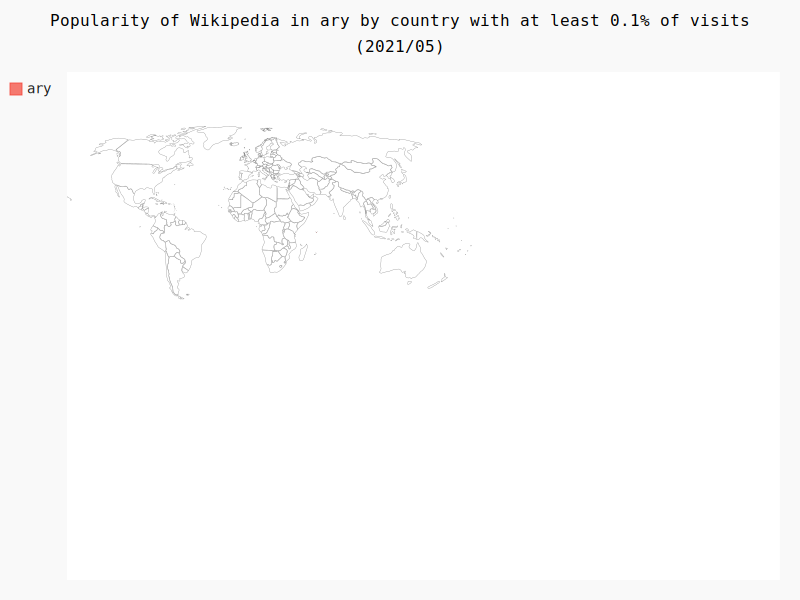

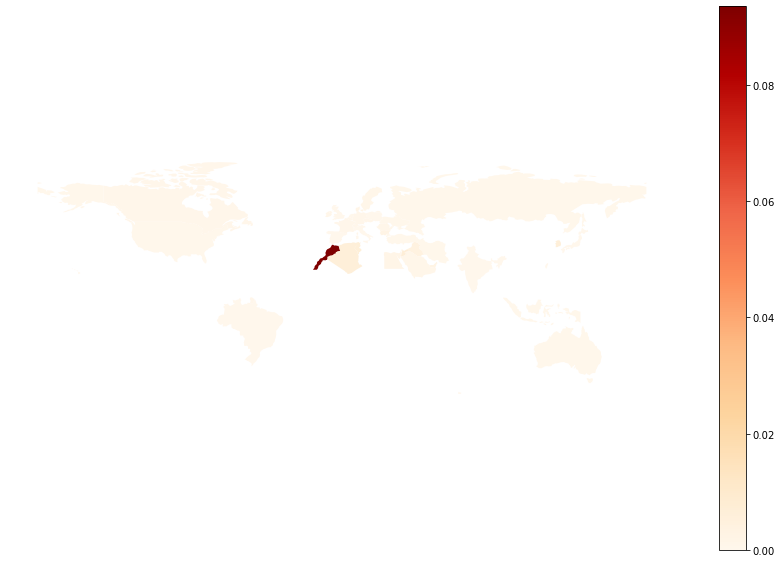

In [19]:
# Percentage instead of absolute numbers
# https://stackoverflow.com/a/42006745/5285608

all_wikipedias_relative = all_wikipedias[all_wikipedias.columns].div(all_wikipedias[all_wikipedias.columns].sum(axis=1), axis=0).multiply(100)

# Language to display
language_code = 'ary'

worldmap_chart = pygal.maps.world.World()
# Threshold in percentage
threshold = 0.1
worldmap_chart.title = 'Popularity of Wikipedia in ' + language_code + ' by country with at least ' + str(threshold) + '% of visits (' + point_in_time + ')'

language_relative = all_wikipedias_relative[language_code].to_dict()

# Country codes to lowercase & filtering based on threshold
language_relative_filtered = {key.lower(): value for key, value in language_relative.items() if value > threshold}

# Countries where this language is the most viewed, descending order
if pd.DataFrame.from_dict(language_relative_filtered, orient='index').empty is False:
    print(pd.DataFrame.from_dict(language_relative_filtered, orient='index').sort_values(by=0, ascending=False))

    # Add to the map
    worldmap_chart.add(language_code, language_relative_filtered)

    # Display in the notebook
    svg_code = worldmap_chart.render()
else:
     print('No country with', language_code, 'above the selected threshold')


# Try another lib
world[language_code] = 0

for key, value in language_relative.items():
    world.loc[world.iso_a2 == key, language_code] = value

params = {
    'column': language_code,
    'figsize': (15, 10),
    'legend': True,
    'cmap': 'OrRd',
    # Wistia
    #'missing_kwds': {
    #    'color': 'white',
    #    'edgecolor': 'lightgrey',
    #    'label': '--',
    #},
}
    
world[world.name != 'Antarctica'].plot(**params).set_axis_off();

display_svg(svg_code)

## For a given language: simplied world map to display countries where it is ranked at least nth

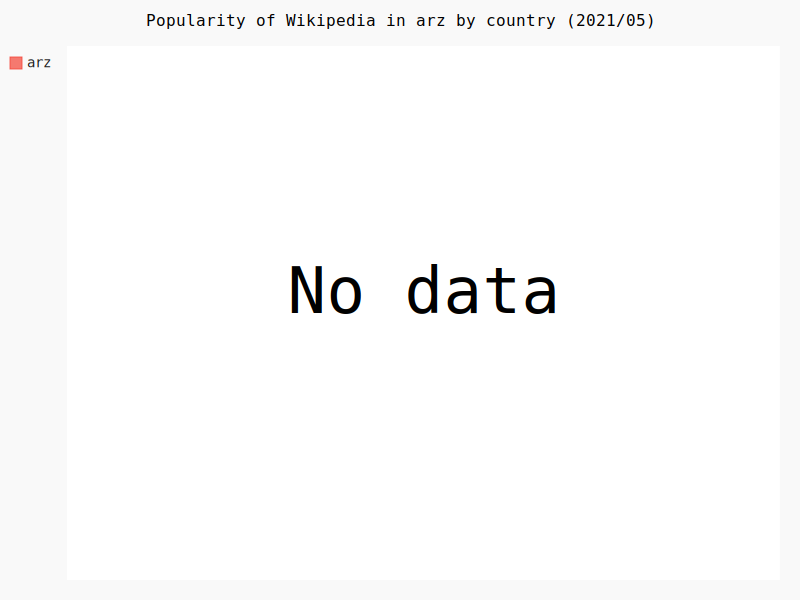

In [15]:
# Language to display
language_code = 'arz'

worldmap_chart = pygal.maps.world.World()

worldmap_chart.title = 'Popularity of Wikipedia in ' + language_code + ' by country (' + point_in_time + ')'

# Rank languages by pageviews in each country
all_wikipedias_ranked = all_wikipedias.rank(axis=1, method='min', ascending=False)
language_ranked = all_wikipedias_ranked[language_code].to_dict()

# We display only countries where rank >= threshold
threshold = 2

# Country codes to lowercase & filtering based on threshold &
# invert ranking for correct gradien display in pygal
language_ranked = {key.lower(): (abs(value - threshold)) for key, value in language_ranked.items() if value <= threshold}

# Add to the map
worldmap_chart.add(language_code, language_ranked)

# Save to file
save = False
if save:
    filename = language_code + '_rank_' + point_in_time.replace('/', '_') + '_chart.svg'
    worldmap_chart.render_to_file(filename)

# Display in the notebook
svg_code = worldmap_chart.render()
display_svg(svg_code)

## Pageviews: Evolution of popular languages over time

In [5]:
# API example:
# https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/fr.wikipedia.org/all-access/user/monthly/20210101/20210201
# https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/de.wikipedia.org/all-sites/monthly/20000101/20150601
base_url = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/'
legacy_base_url = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/'

# Create empty DataFrame
all_languages_pageviews = pd.DataFrame()

start_date = '20101101'
end_date = date.today().strftime('%Y%m%d')
date_range = start_date + '/' + end_date

# For each Wikipedia get the total list of page views
for code in wiki_codes:
    project = code + '.wikipedia.org'

    # First, legacy data, from 2007120100 to 2015060100
    # Get the data from the API
    legacy_pageviews_url = legacy_base_url + project + '/all-sites/monthly/2000010101/2015070101'
    legacy_pageviews_json = requests.get(legacy_pageviews_url, headers=headers).text
    legacy_pageviews = json.loads(legacy_pageviews_json)

    # Exclude projects for which the API fails (e.g. bdr.wikipedia.org)
    if 'items' in legacy_pageviews:
        legacy_available = True

        # Transform to a dataframe
        legacy_df = pd.DataFrame.from_dict(legacy_pageviews['items'])

        # Drop useless columns
        legacy_df = legacy_df.drop(columns=['project', 'access-site', 'granularity'])

        # Rename one column
        legacy_df = legacy_df.rename(columns={'count': code})
    else:
        legacy_available = False

    # Then, new data, from 2015070100 to today
    # Get the data from the API
    pageviews_url = base_url + project + '/all-access/user/monthly/' + date_range
    pageviews_json = requests.get(pageviews_url, headers=headers).text
    pageviews = json.loads(pageviews_json)

    # Exclude projects for which the API fails (e.g. bdr.wikipedia.org)
    if 'items' in pageviews:
        new_available = True

        # Transform to a dataframe
        df = pd.DataFrame.from_dict(pageviews['items'])

        # Drop useless columns
        df = df.drop(columns=['project', 'access', 'agent', 'granularity'])

        # Rename one column
        df = df.rename(columns={'views': code})
    else:
        new_available = False
        print(project, ' failed')
    
    if legacy_available:
        # Concatenate legacy data and new data
        df = pd.concat([legacy_df, df])
    
    # If no
    if not new_available and not legacy_available:
        continue

    # Set index
    df = df.set_index('timestamp')
    
    # Merging the dataframes on the country key with outer join
    all_languages_pageviews = pd.concat([all_languages_pageviews, df], axis=1)

# Divide each row by the sum of the row to get %
all_languages_pageviews_pct = all_languages_pageviews.divide(all_languages_pageviews.sum(axis=1), axis=0)

bdr.wikipedia.org  failed
gsw.wikipedia.org  failed
lzh.wikipedia.org  failed
nan.wikipedia.org  failed
rup.wikipedia.org  failed
sgs.wikipedia.org  failed
vro.wikipedia.org  failed
yue.wikipedia.org  failed


en    0.520670
ja    0.061944
de    0.053609
ru    0.052969
es    0.050457
fr    0.044580
zh    0.032780
it    0.028941
fa    0.015973
pt    0.015371
Name: 0, dtype: float64
Test mode:  False


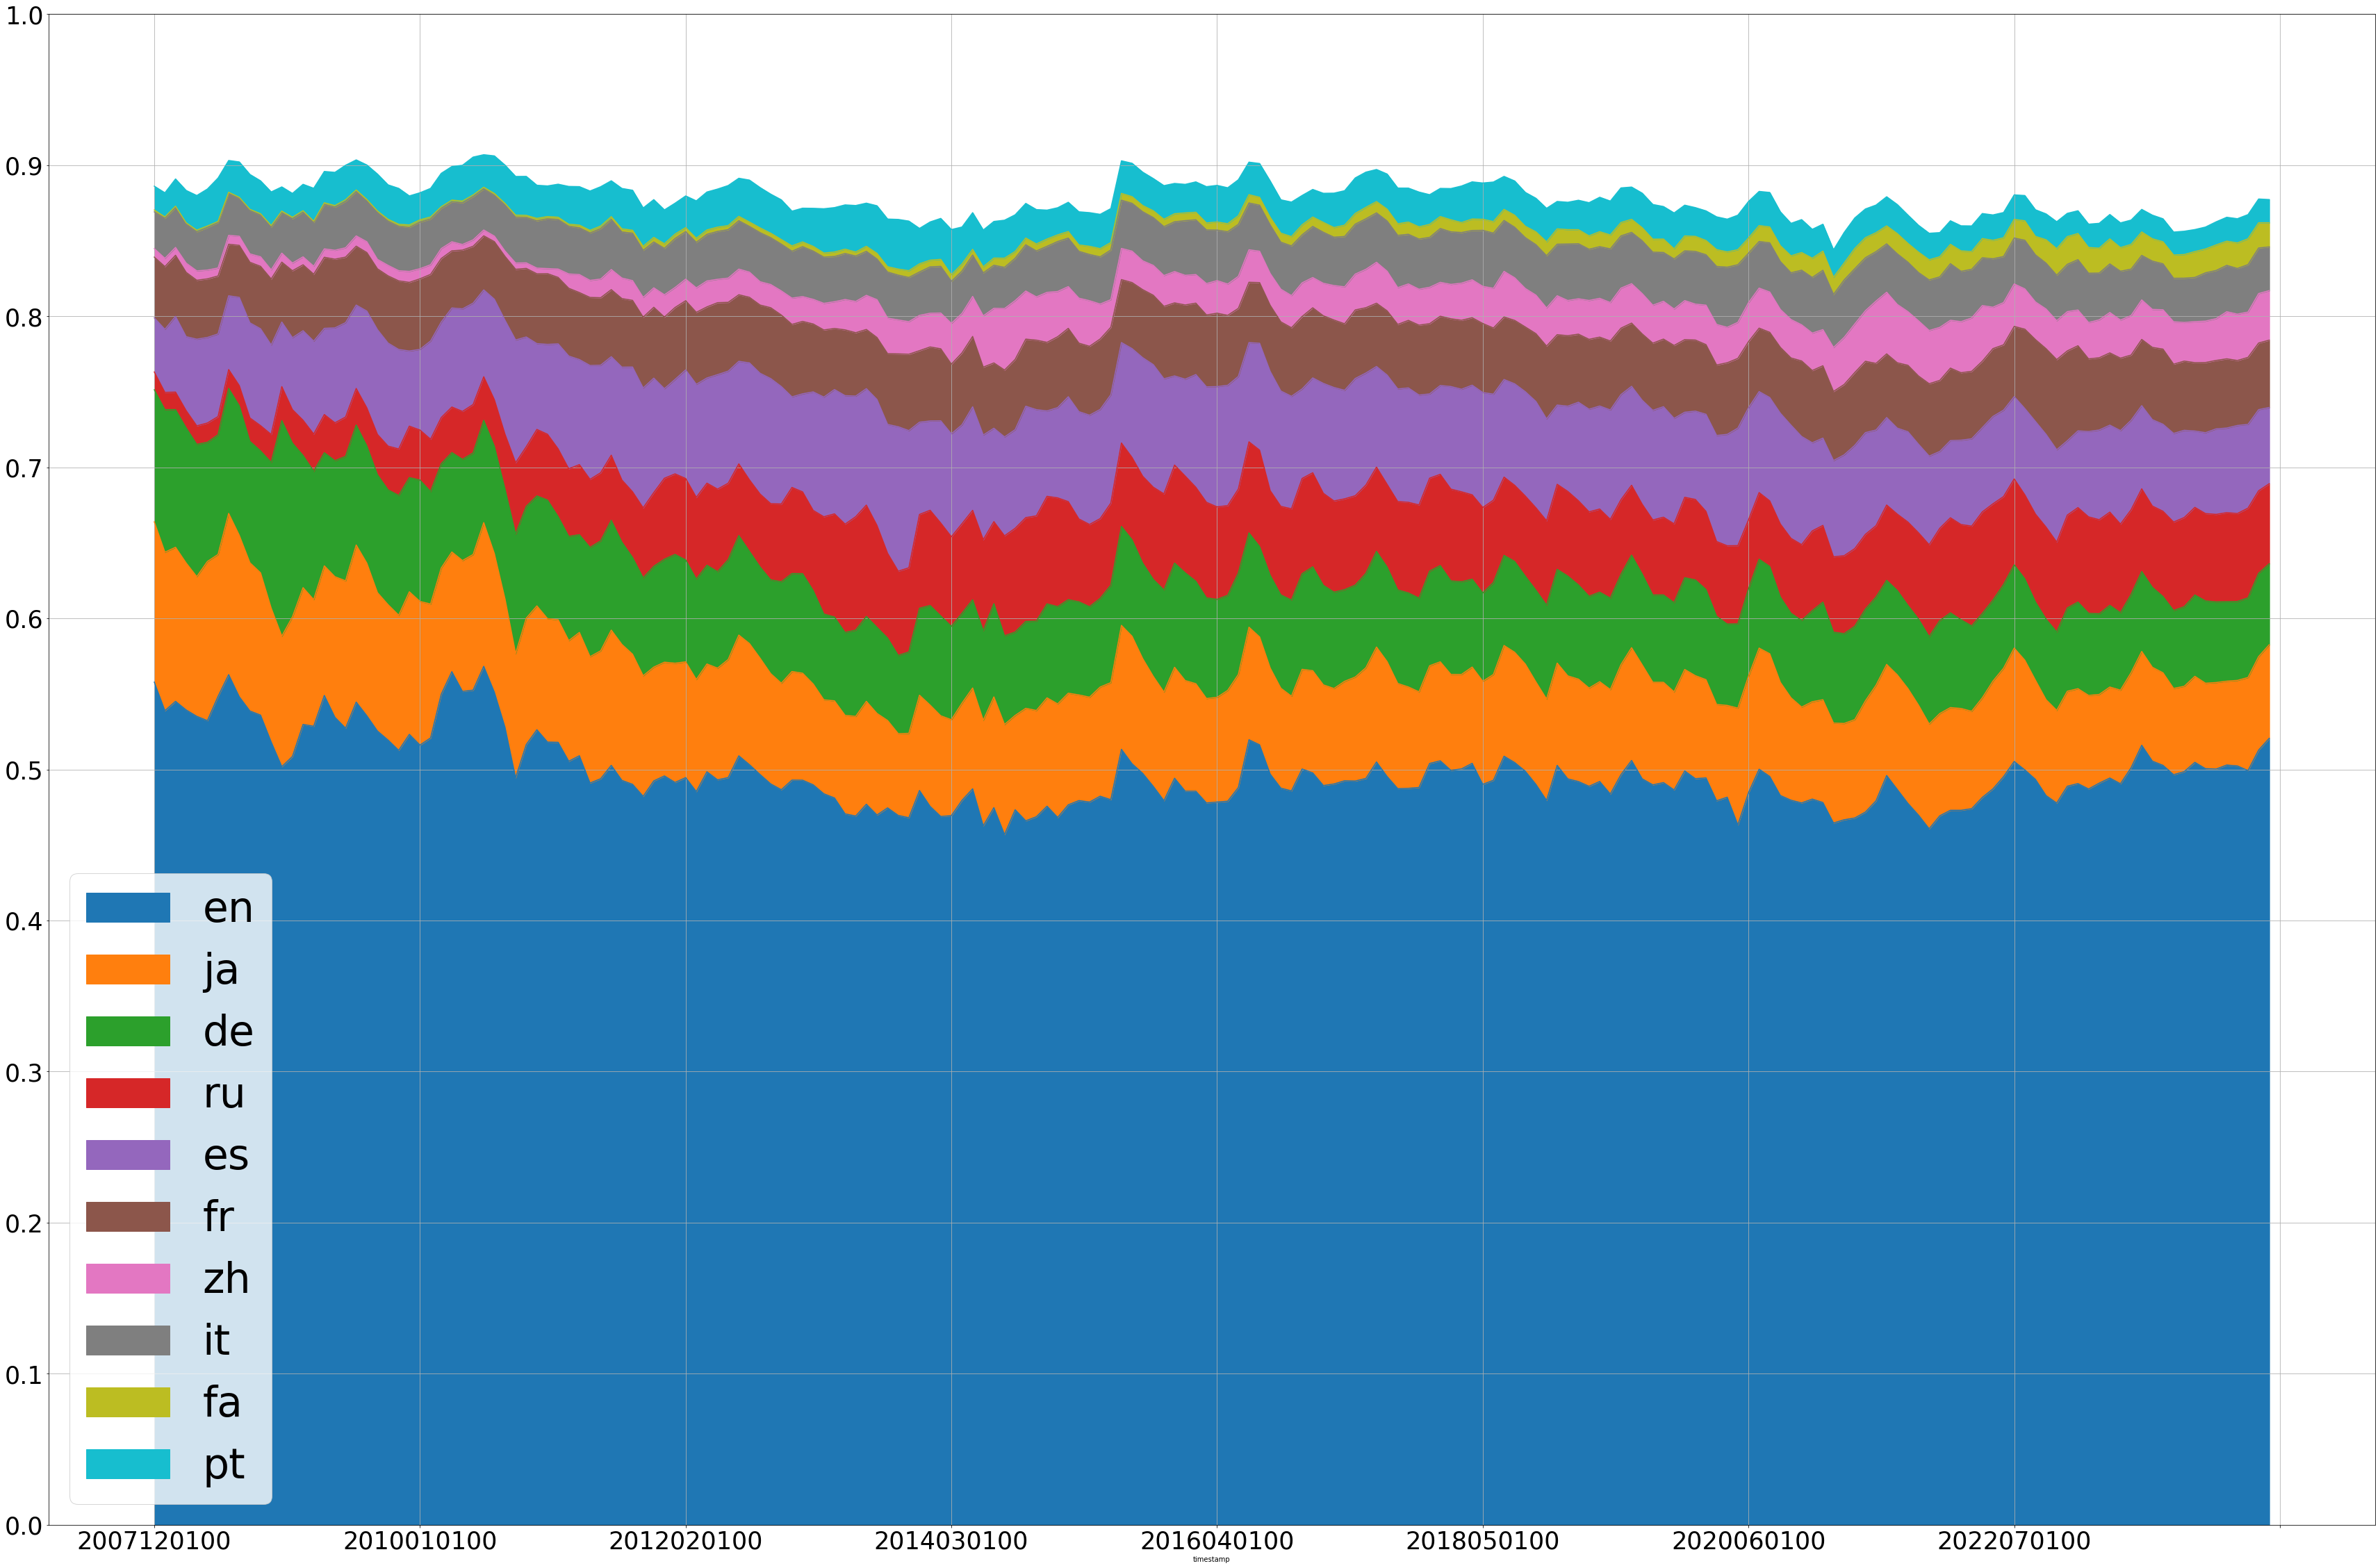

In [10]:
# Only display the most viewed
# https://meta.wikimedia.org/wiki/List_of_Wikipedias/Table2

n_top = 10
most_viewed_wp_values = all_languages_pageviews_pct.iloc[[-1]].reset_index().drop(columns='timestamp').transpose().nlargest(n=n_top, columns=0)[0]
print(most_viewed_wp_values)

print('Test mode: ', test_mode)
if test_mode:
    most_viewed_wp = wiki_codes
else:
    # most_viewed_wp = [
    #    'en', 'ja', 'es', 'de', 'ru', 'fr', 'it', 'zh', 'pt', 'pl',
        # 'ar', 'fa', 'nl', 'tr', 'id',
    # ]
    most_viewed_wp = most_viewed_wp_values.index.to_list()

params = {
    'y': most_viewed_wp,
    'figsize': (60,40),
    'fontsize': 35,
    'yticks': [x/10 for x in range(11)],
    'grid': True,
    'legend': False,
}
ax = all_languages_pageviews_pct.plot.area(**params)
leg = ax.legend(loc=3, prop={'size': 60})

In [98]:
# Relative evolution of some Wikipedias

params = {
    # 'y': ['ar', 'fa', 'id', 'nl', 'tr', 'sv', 'ko', 'vi', 'cs', 'uk', 'he', 'th', 'hi'],
    'y': ['pl', 'ar', 'fa'],
    'figsize': (30,20),
    # 'fontsize': 30,
    # 'yticks': [x/10 for x in range(11)],
    # 'grid': True,
    'legend': True,
    # 'logy': True,
}

graph = all_languages_pageviews.plot(**params)

KeyError: "None of [Index(['pl', 'ar', 'fa'], dtype='object')] are in the [columns]"

## Editors: Evolution of popular languages over time

In [16]:
# API example:
# https://wikimedia.org/api/rest_v1/metrics/editors/aggregate/ar.wikipedia.org/all-editor-types/all-page-types/all-activity-levels/monthly/2000010101/2021010101

base_url = 'https://wikimedia.org/api/rest_v1/metrics/editors/aggregate/'

all_languages_editors = pd.DataFrame()

start_date = '2000010101'
end_date = date.today().strftime('%Y%m%d')
date_range = start_date + '/' + end_date + '01'

for code in wiki_codes:
    # For each Wikipedia get the number of editors
    project = code + '.wikipedia.org'

    editors_url = base_url + project + '/all-editor-types/all-page-types/all-activity-levels/monthly/' + date_range

    editors_json = requests.get(editors_url, headers=headers).text

    editors = json.loads(editors_json)

    # Exclude projects for which the API fails (e.g. bdr.wikipedia.org)
    if 'status' in editors:
        if editors['status'] == 404:
            print(project, ' failed, continuing to the next one')
            continue

    # Transform to a dataframe
    df = pd.DataFrame.from_dict(editors['items'][0]['results'])
    
    # Rename one column
    df = df.rename(columns={'editors': code})

    # Set index
    df = df.set_index('timestamp')
    
    # Merging the dataframes on the country key with outer join
    all_languages_editors = pd.concat([all_languages_editors, df], axis=1)

# Divide each row by the sum of the row to get %
all_languages_editors_pct = all_languages_editors.divide(all_languages_editors.sum(axis=1), axis=0)

aa.wikipedia.org  failed, continuing to the next one
ak.wikipedia.org  failed, continuing to the next one
bdr.wikipedia.org  failed, continuing to the next one
bew.wikipedia.org  failed, continuing to the next one
btm.wikipedia.org  failed, continuing to the next one
cho.wikipedia.org  failed, continuing to the next one
dtp.wikipedia.org  failed, continuing to the next one
gsw.wikipedia.org  failed, continuing to the next one
ho.wikipedia.org  failed, continuing to the next one
hz.wikipedia.org  failed, continuing to the next one
igl.wikipedia.org  failed, continuing to the next one
ii.wikipedia.org  failed, continuing to the next one
kj.wikipedia.org  failed, continuing to the next one
kr.wikipedia.org  failed, continuing to the next one
kus.wikipedia.org  failed, continuing to the next one
lrc.wikipedia.org  failed, continuing to the next one
lzh.wikipedia.org  failed, continuing to the next one
mh.wikipedia.org  failed, continuing to the next one
mus.wikipedia.org  failed, continuin

en    0.423553
es    0.072487
de    0.057831
fr    0.056259
it    0.045967
ru    0.045064
ja    0.038519
fa    0.025079
zh    0.022830
he    0.015137
Name: 2024-07-01 00:00:00+00:00, dtype: float64


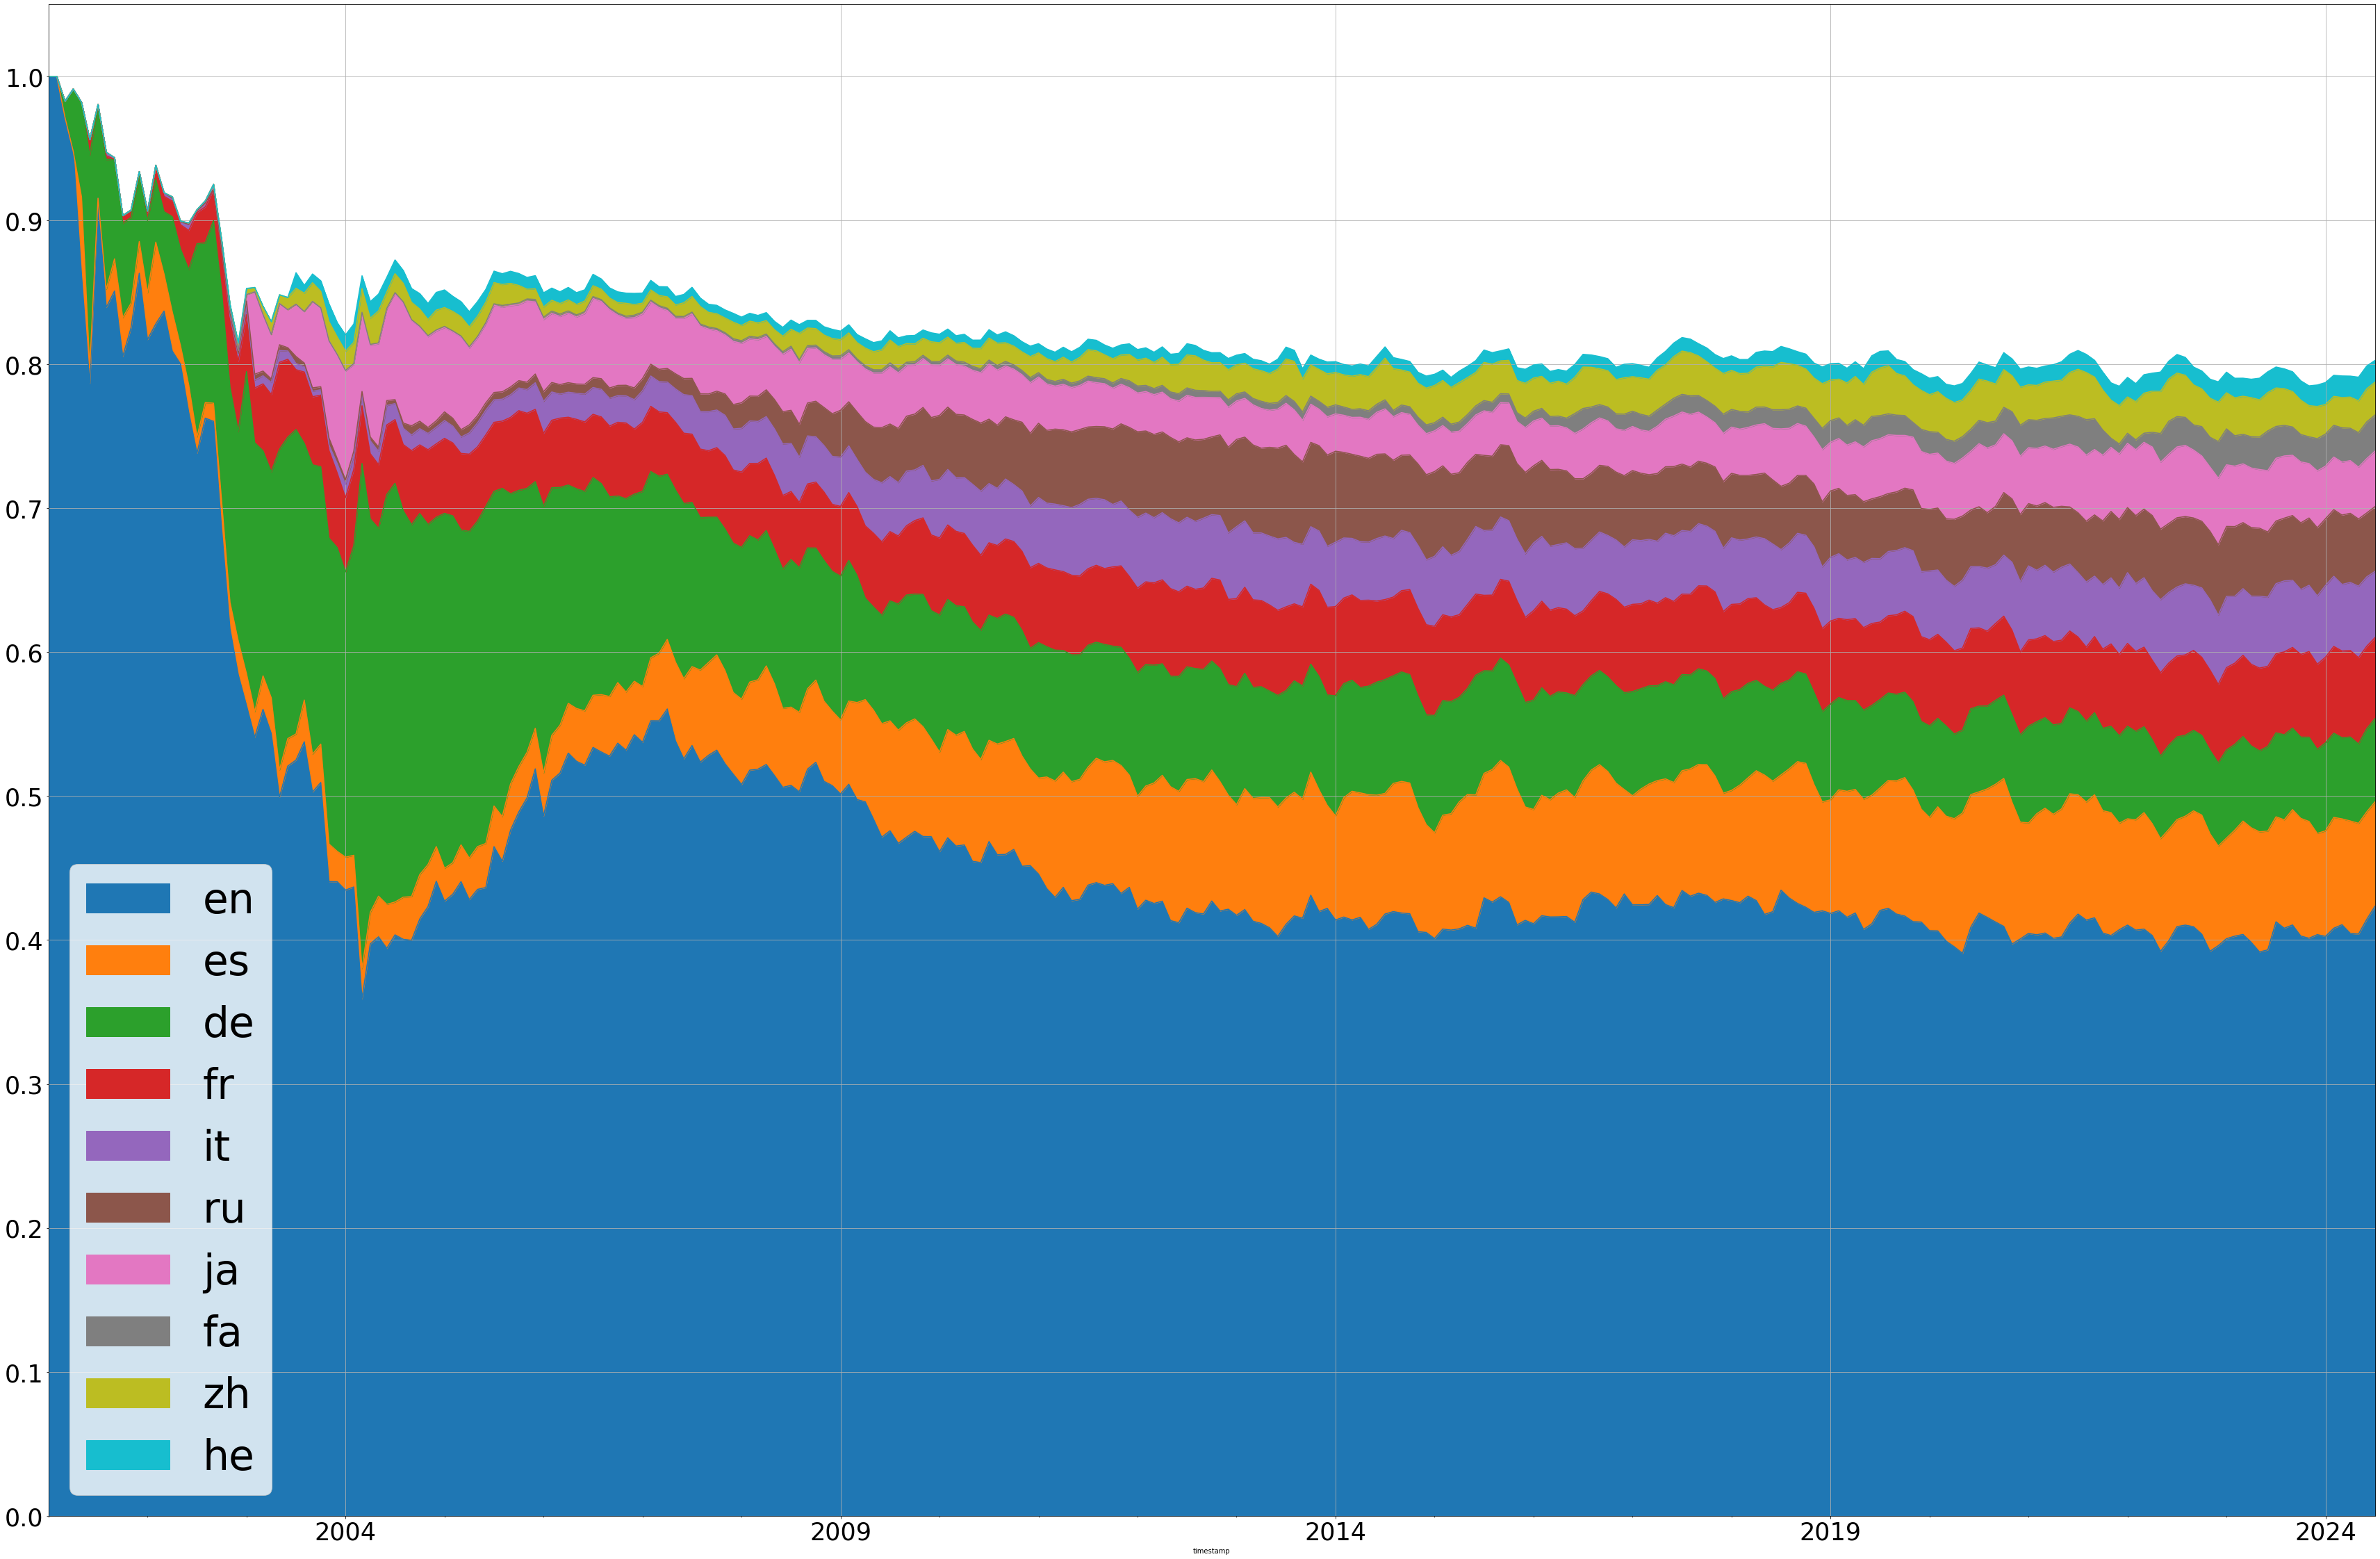

In [22]:
# Only display editions with the most editors
# https://meta.wikimedia.org/wiki/List_of_Wikipedias/Table2

n_top = 10

# Ensure the index is of datetime type if it isn't already
all_languages_editors_pct.index = pd.to_datetime(all_languages_editors_pct.index)

# Sort the DataFrame by the index (timestamp) to ensure it is in chronological order
all_languages_editors_pct = all_languages_editors_pct.sort_index()

# Select the last row which corresponds to the latest timestamp
latest_month_data = all_languages_editors_pct.iloc[-1]

# Get the top 10 languages by value
top_wp_editors_values = latest_month_data.nlargest(n=n_top)

print(top_wp_editors_values)

if test_mode:
    top_wp_editors = wiki_codes
else:
    #top_wp_editors = [
    #    'en', 'es', 'de', 'fr', 'it', 'ru', 'ja', 'zh', 'fa', 'ar',
        # 'pl', 'nl', 'pt', 'tr', 'id',
   # ]
    top_wp_editors = top_wp_editors_values.index.to_list()

params = {
    'y': top_wp_editors,
    'figsize': (60,40),
    'fontsize': 35,
    'yticks': [x/10 for x in range(11)],
    'grid': True,
    'legend': False,
}
ax = all_languages_editors_pct.plot.area(**params)
leg = ax.legend(loc=3, prop={'size': 60})

## Top countries

In [52]:
# For each project, get the distribution of visits by country

# API Example:
# https://wikimedia.org/api/rest_v1/metrics/pageviews/top-by-country/fr.wikipedia.org/all-access/2021/01

base_url = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/top-by-country/'
# 'xx.wikipedia.org' or 'all-projects'
project = 'la.wikipedia.org'

top_countries_hist = pd.DataFrame()

start_date = date(2015, 5, 1)

# Loop over the months
for dt in rrule.rrule(rrule.MONTHLY, dtstart=start_date, until=last_month):
    # Format the month
    analyzed_month = dt.strftime('%Y/%m')
    
    # For each month, get page views by country for the project
    top_countries_url = base_url + project + '/all-access/' + analyzed_month
    top_countries_json = requests.get(top_countries_url, headers=headers).text
    top_countries = json.loads(top_countries_json)

    # Move to next month if empty table
    if 'items' not in top_countries:
        continue

    # Transform to a dataframe
    df = pd.DataFrame.from_dict(top_countries['items'][0]['countries'])

    # Drop useless columns
    df = df.drop(columns=['views', 'rank'])

    # Rename one column
    df = df.rename(columns={'views_ceil': analyzed_month})

    # Set index
    df = df.set_index('country')

    # Merging the dataframes on the country key with outer join
    top_countries_hist = pd.concat([top_countries_hist, df], axis=1)

    # Divide each column by the sum of the column to get %
    top_countries_hist_pct = top_countries_hist.divide(top_countries_hist.sum(axis=0), axis=1)

### Plot page views breakdown by country over time

la.wikipedia.org


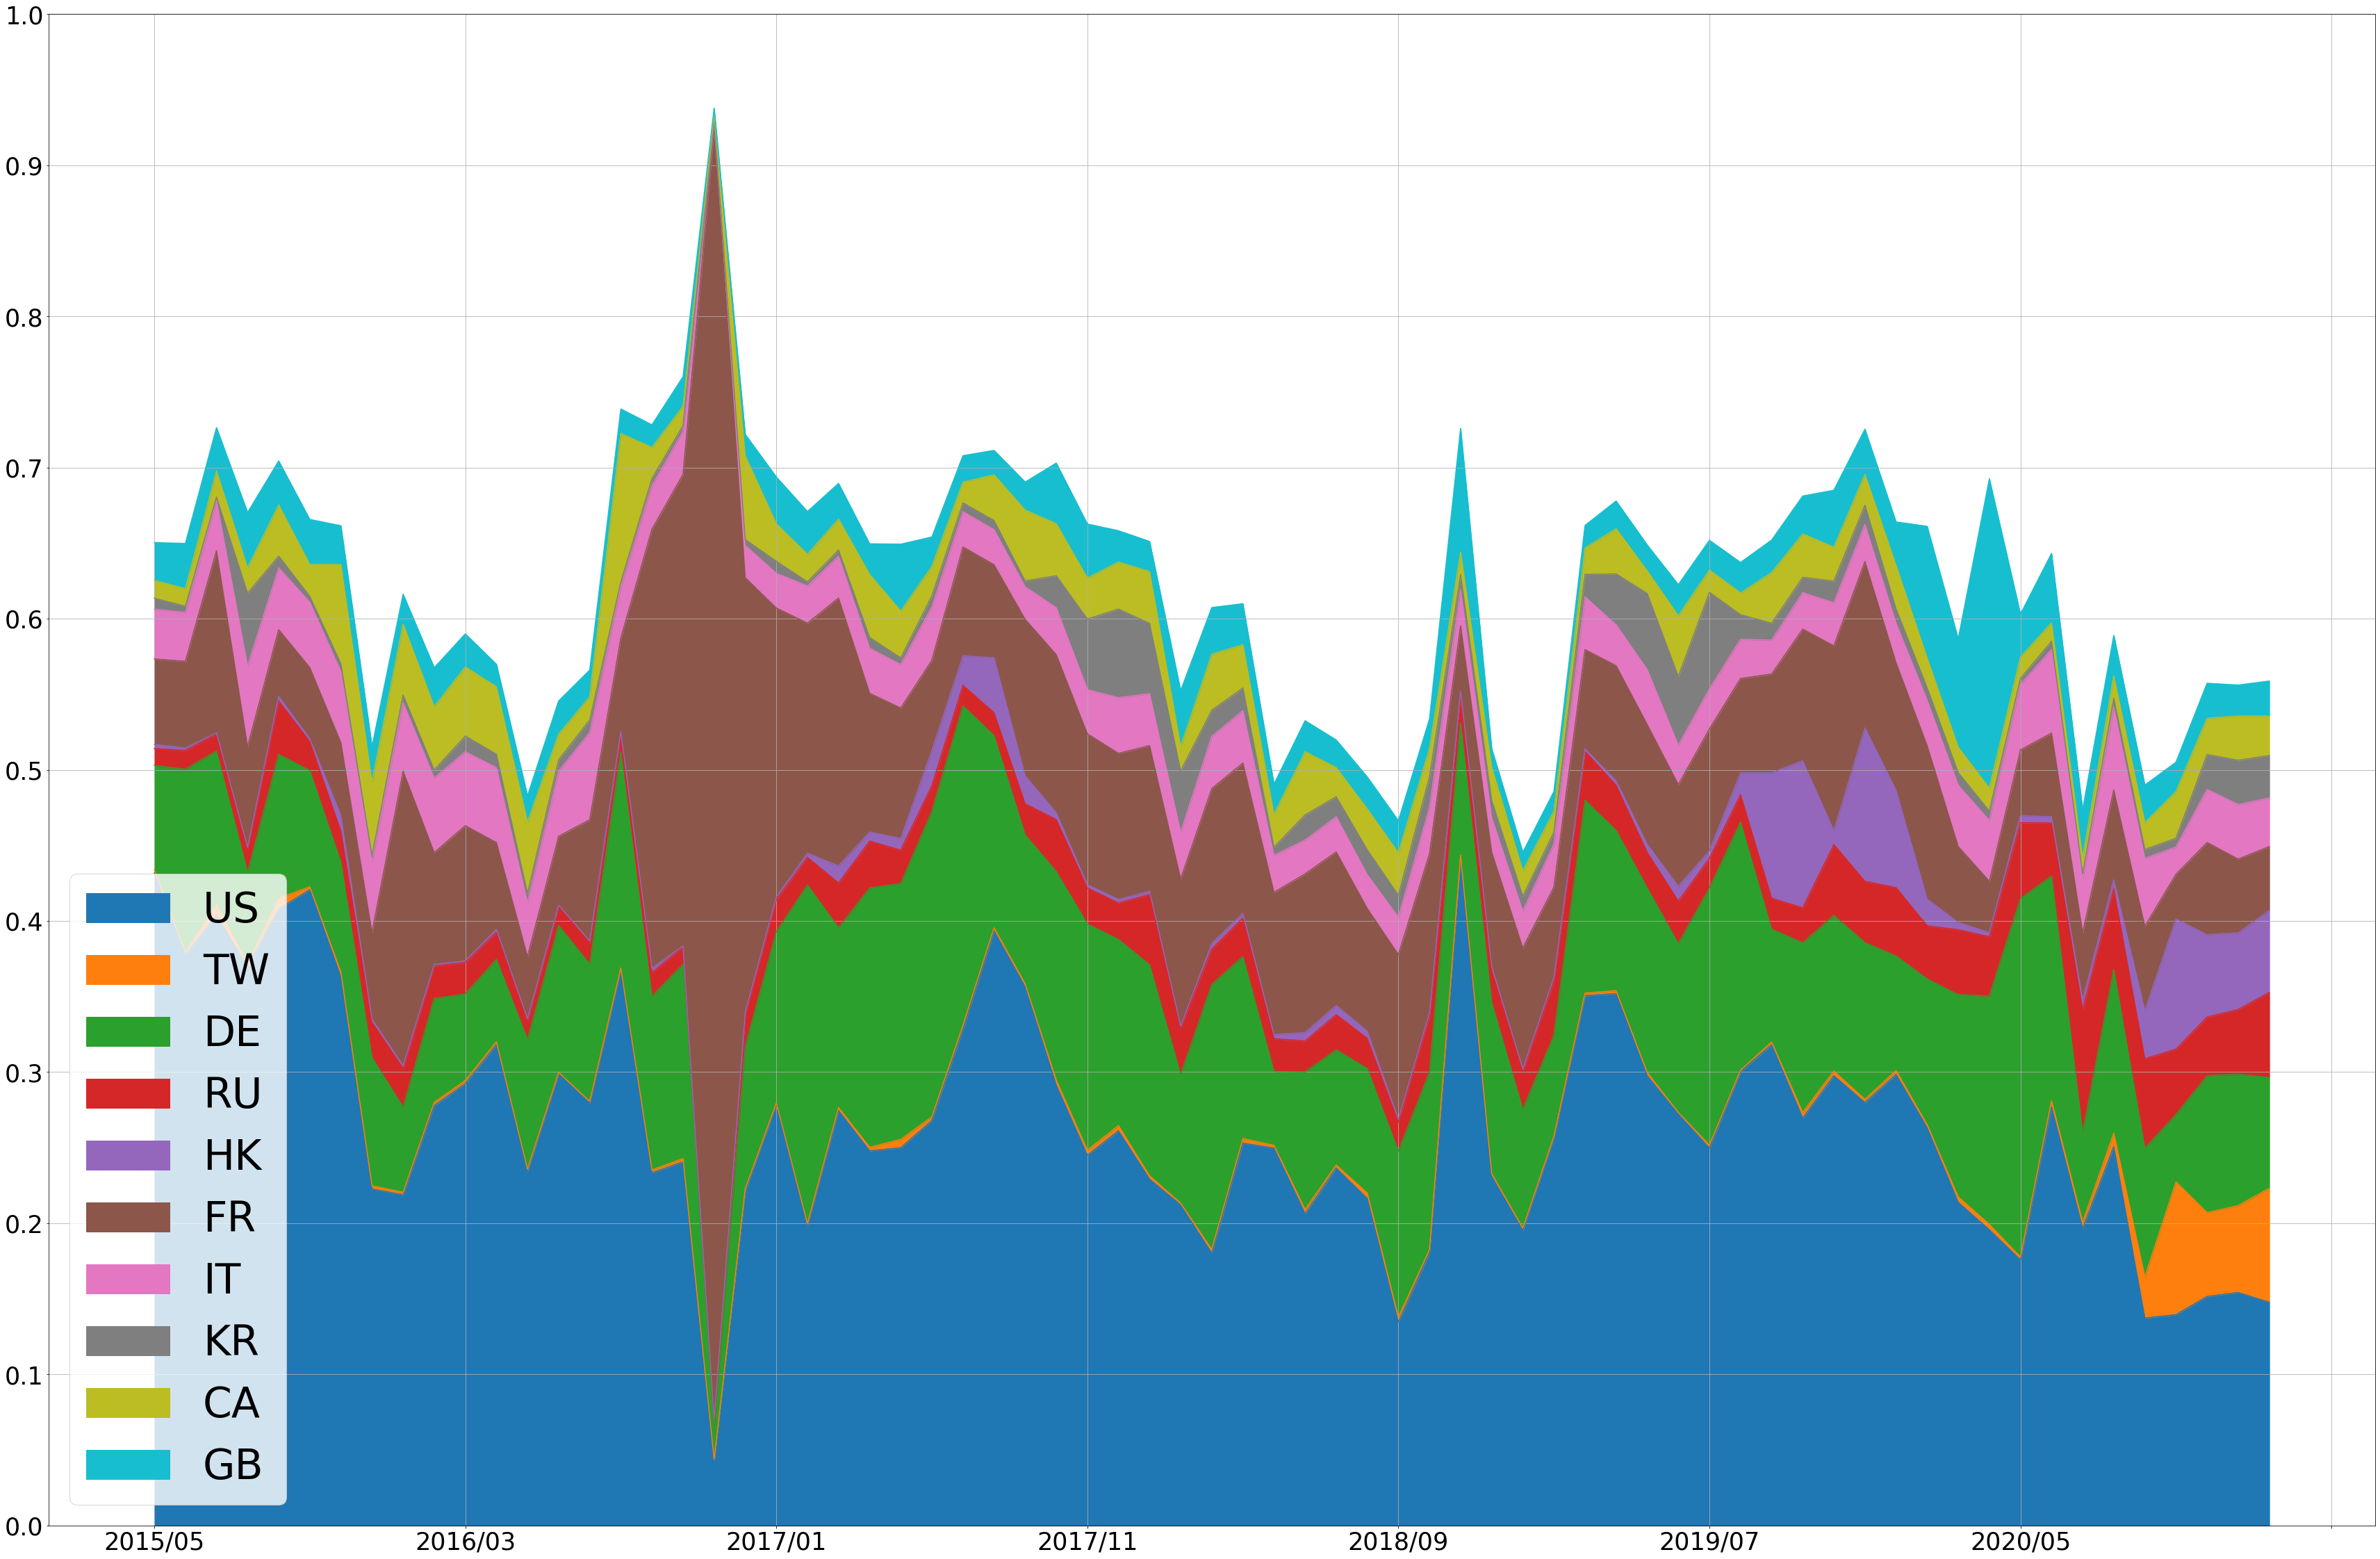

In [54]:
n_top = 10
top_countries_names = top_countries_hist_pct.iloc[:,-1:].nlargest(n=n_top, columns=analyzed_month).index.to_list()
print(project)

params = {
    'y': top_countries_names,
    'figsize': (60,40),
    'fontsize': 35,
    'yticks': [x/10 for x in range(11)],
    'grid': True,
    'legend': False,
}
ax = top_countries_hist_pct.transpose().plot.area(**params)
leg = ax.legend(loc=3, prop={'size': 60})